<h1> Parameter Tuning 
    
    Look at n_neurons & n_hidden layers

# Importing libraries:

In [37]:
!pip install pandas
!pip install sklearn

import pandas as pd;
import numpy as np;
import sklearn

# Import data; set X and y; fill nan values and split in test and training  data:

In [38]:
# import data
data = pd.read_csv('Data_set_1_smaller.csv', index_col = 0)

# for later use
features_num = 15

# 2018 data
data = data.loc[data.index > 2018070000, :]

# reset index
data.reset_index(inplace = True)
data.drop('index', axis = 1, inplace = True)

# fill nan values
data.fillna(method = 'ffill', inplace = True)

from sklearn.model_selection import train_test_split

# divide data into train and test 
data_train, data_test = train_test_split(
         data, test_size = 0.15, shuffle=False)

# Apply feature scaling:

In [39]:
from sklearn.preprocessing import MinMaxScaler

# data scaling  (including offer (y))
sc_X = MinMaxScaler()
data_train = sc_X.fit_transform(data_train)
data_test = sc_X.transform(data_test)

# Importing packages:

In [40]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras import initializers
from keras import optimizers
from keras.callbacks import EarlyStopping

mae_gen = []
rmse_gen = []
mae_nor = []
mae_spi = []
rmse_nor = []
rmse_spi = []
hist_list = []
y_pred_list = []
prediction_list = []
time_count = []

# Prepare of data according to LSTM needs,  create regressor & tune:

In [41]:
# parameters
steps = 96
#n_hidden = 1
#units = 100
batch_size = 96

from sklearn.model_selection import ParameterGrid

# no hidden or one hidden layer
parameters = {'n_hidden': [1, 2],
              'units': [50, 100, 150, 200]}

all_param = ParameterGrid(parameters)

# function to split data into correct shape for RNN
def split_data(X, y, steps):
    X_, y_ = list(), list()
    for i in range(steps, len(y)):
        X_.append(X[i - steps : i, :])
        y_.append(y[i]) 
    return np.array(X_), np.array(y_)

# function to cut data set so it can be divisible by the batch_size
def cut_data(data, batch_size):
     # see if it is divisivel
    condition = data.shape[0] % batch_size
    if condition == 0:
        return data
    else:
        return data[: -condition]

# divide features and labels
X_train = data_train[:, 0:15] 
y_train = data_train[:, -1]
X_test = data_test[:, 0:15] 
y_test = data_test[:, -1] 

# divide data into train and test 
X_train, X_val, y_train, y_val = train_test_split(
         X_train, y_train, test_size = 0.15, shuffle=False)

# put data into correct shape
X_train, y_train = split_data(X_train, y_train, steps)
X_test, y_test = split_data(X_test, y_test, steps)
X_val, y_val = split_data(X_val, y_val, steps)

X_train = cut_data(X_train, batch_size)
y_train = cut_data(y_train, batch_size)
X_test = cut_data(X_test, batch_size)
y_test = cut_data(y_test, batch_size)
X_val = cut_data(X_val, batch_size)
y_val = cut_data(y_val, batch_size)

# design the LSTM
def regressor_tunning(kernel_initializer = 'he_normal',
                      bias_initializer = initializers.Ones()):
    model = Sequential()
    if n_hidden == 0:
        model.add(LSTM(units = units,                    
                       batch_input_shape = (batch_size, steps, features_num), 
                       stateful = True,
                       kernel_initializer = kernel_initializer,
                       bias_initializer = bias_initializer))
        model.add(LeakyReLU(alpha = 0.2))
        model.add(Dropout(0.2))
    else:
        model.add(LSTM(units = units,                    
                       batch_input_shape = (batch_size, steps, features_num), 
                       stateful = True,
                       return_sequences = True,
                       kernel_initializer = kernel_initializer,
                       bias_initializer = bias_initializer))
        model.add(LeakyReLU(alpha = 0.2))
        model.add(Dropout(0.2))
        model.add(LSTM(units = units, 
                       batch_input_shape = (batch_size, steps, features_num), 
                       stateful = True,
                       kernel_initializer = kernel_initializer,
                       bias_initializer = bias_initializer))
        model.add(LeakyReLU(alpha = 0.2))
        model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))
    model.compile(loss = 'mse', metrics = ['mse', 'mae'], optimizer = 'Adamax')
    return model

# inverse of test set should not be inside the loop 
y_test = (y_test * sc_X.data_range_[15]) + (sc_X.data_min_[15])

for i in range(len(all_param)):
    
    units = all_param[i]['units']
    n_hidden = all_param[i]['n_hidden']
    
    model = regressor_tunning()

    # fitting the LSTM to the training set
    history = model.fit(X_train,
                        y_train, 
                        batch_size = batch_size, 
                        epochs = 180,
                        shuffle = False, 
                        validation_data = (X_val, y_val))
    
    model.reset_states()
    
    # make new predicitons with test set
    y_pred = model.predict(X_test, batch_size = batch_size)
    
    # prices col = 15
    y_pred = (y_pred * sc_X.data_range_[15]) + (sc_X.data_min_[15])

    y_pred_list.append(y_pred)
    
    from sklearn.metrics import mean_squared_error as mse
    from sklearn.metrics import mean_absolute_error as mae

    rmse_error = mse(y_test, y_pred, squared = False)
    mae_error = mae(y_test, y_pred)
    
    rmse_gen.append(rmse_error)
    mae_gen.append(mae_error)
    
    # =============================================================================
    # Metrics evaluation on spike regions
    # =============================================================================
    
    y_spike_occ = pd.read_csv('Spike_binary_1std.csv', usecols = [6])
    
    # create array same size as y_test
    y_spike_occ = y_spike_occ.iloc[- len(y_test):]
    y_spike_occ = pd.Series(y_spike_occ.iloc[:,0]).values
    
    # smal adjustment
    y_test = pd.Series(y_test)
    y_test.replace(0, 0.0001,inplace = True)

    # select y_pred and y_test only for regions with spikes
    y_test_spike = (y_test.T * y_spike_occ).T
    y_pred_spike = (y_pred.T * y_spike_occ).T
    y_test_spike = y_test_spike[y_test_spike != 0]
    y_pred_spike = y_pred_spike[y_pred_spike != 0]
    
    # calculate metric
    rmse_spike = mse(y_test_spike, y_pred_spike, squared = False)
    mae_spike = mae(y_test_spike, y_pred_spike)
    
    rmse_spi.append(rmse_spike)
    mae_spi.append(mae_spike)
    
    # =============================================================================
    # Metric evaluation on normal regions
    # =============================================================================
    
    # inverse y_spike_occ so the only normal occurences are chosen
    y_normal_occ = (y_spike_occ - 1) * (-1)
    
    # sanity check
    y_normal_occ.sum() + y_spike_occ.sum() # gives the correct total 
    
    # select y_pred and y_test only for normal regions
    y_test_normal = (y_test.T * y_normal_occ).T
    y_pred_normal = (y_pred.T * y_normal_occ).T
    y_test_normal = y_test_normal[y_test_normal != 0.00]
    y_pred_normal = y_pred_normal[y_pred_normal != 0.00]
    
    # calculate metric
    rmse_normal = mse(y_test_normal, y_pred_normal, squared = False)
    mae_normal = mae(y_test_normal, y_pred_normal)
    
    rmse_nor.append(rmse_normal)
    mae_nor.append(mae_normal)

Epoch 1/180
65/65 [==============================] - 23s 351ms/step - loss: 0.1158 - mse: 0.1158 - mae: 0.2701 - val_loss: 0.0033 - val_mse: 0.0033 - val_mae: 0.0425
Epoch 2/180
65/65 [==============================] - 20s 311ms/step - loss: 0.0632 - mse: 0.0632 - mae: 0.2009 - val_loss: 0.0021 - val_mse: 0.0021 - val_mae: 0.0329
Epoch 3/180
65/65 [==============================] - 19s 286ms/step - loss: 0.0409 - mse: 0.0409 - mae: 0.1608 - val_loss: 0.0014 - val_mse: 0.0014 - val_mae: 0.0242
Epoch 4/180
65/65 [==============================] - 19s 297ms/step - loss: 0.0281 - mse: 0.0281 - mae: 0.1328 - val_loss: 0.0013 - val_mse: 0.0013 - val_mae: 0.0199
Epoch 5/180
65/65 [==============================] - 19s 297ms/step - loss: 0.0203 - mse: 0.0203 - mae: 0.1122 - val_loss: 0.0012 - val_mse: 0.0012 - val_mae: 0.0234
Epoch 6/180
65/65 [==============================] - 19s 291ms/step - loss: 0.0152 - mse: 0.0152 - mae: 0.0974 - val_loss: 0.0014 - val_mse: 0.0014 - val_mae: 0.0223
Epoc

65/65 [==============================] - 14s 208ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0197 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0186
Epoch 51/180
65/65 [==============================] - 14s 209ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0194 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0189
Epoch 52/180
65/65 [==============================] - 13s 203ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0193 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0186
Epoch 53/180
65/65 [==============================] - 14s 209ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0193 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0186
Epoch 54/180
65/65 [==============================] - 14s 209ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0190 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0189
Epoch 55/180
65/65 [==============================] - 14s 210ms/step - loss: 9.9157e-04 - mse: 9.9157e-04 - mae: 0.0189 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0186
Epo

65/65 [==============================] - 15s 237ms/step - loss: 9.1504e-04 - mse: 9.1504e-04 - mae: 0.0178 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0185
Epoch 98/180
65/65 [==============================] - 15s 232ms/step - loss: 9.1416e-04 - mse: 9.1416e-04 - mae: 0.0179 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0186
Epoch 99/180
65/65 [==============================] - 15s 226ms/step - loss: 9.1485e-04 - mse: 9.1485e-04 - mae: 0.0178 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0186
Epoch 100/180
65/65 [==============================] - 15s 231ms/step - loss: 9.1348e-04 - mse: 9.1348e-04 - mae: 0.0178 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0187
Epoch 101/180
65/65 [==============================] - 15s 223ms/step - loss: 9.1149e-04 - mse: 9.1149e-04 - mae: 0.0178 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0186
Epoch 102/180
65/65 [==============================] - 15s 230ms/step - loss: 9.1474e-04 - mse: 9.1474e-04 - mae: 0.0178 - val_loss: 0.0

Epoch 143/180
65/65 [==============================] - 15s 223ms/step - loss: 8.6139e-04 - mse: 8.6139e-04 - mae: 0.0169 - val_loss: 8.4613e-04 - val_mse: 8.4613e-04 - val_mae: 0.0182
Epoch 144/180
65/65 [==============================] - 15s 226ms/step - loss: 8.6587e-04 - mse: 8.6587e-04 - mae: 0.0170 - val_loss: 8.6869e-04 - val_mse: 8.6869e-04 - val_mae: 0.0187
Epoch 145/180
65/65 [==============================] - 15s 237ms/step - loss: 8.5755e-04 - mse: 8.5755e-04 - mae: 0.0168 - val_loss: 8.7831e-04 - val_mse: 8.7831e-04 - val_mae: 0.0186
Epoch 146/180
65/65 [==============================] - 15s 225ms/step - loss: 8.5980e-04 - mse: 8.5980e-04 - mae: 0.0168 - val_loss: 8.4720e-04 - val_mse: 8.4720e-04 - val_mae: 0.0179
Epoch 147/180
65/65 [==============================] - 14s 223ms/step - loss: 8.5843e-04 - mse: 8.5843e-04 - mae: 0.0168 - val_loss: 8.6682e-04 - val_mse: 8.6682e-04 - val_mae: 0.0184
Epoch 148/180
65/65 [==============================] - 14s 221ms/step - loss: 8.

65/65 [==============================] - 42s 652ms/step - loss: 0.0096 - mse: 0.0096 - mae: 0.0764 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0199
Epoch 9/180
65/65 [==============================] - 43s 663ms/step - loss: 0.0080 - mse: 0.0080 - mae: 0.0704 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0229
Epoch 10/180
65/65 [==============================] - 44s 673ms/step - loss: 0.0068 - mse: 0.0068 - mae: 0.0643 - val_loss: 0.0012 - val_mse: 0.0012 - val_mae: 0.0265
Epoch 11/180
65/65 [==============================] - 41s 626ms/step - loss: 0.0055 - mse: 0.0055 - mae: 0.0578 - val_loss: 0.0015 - val_mse: 0.0015 - val_mae: 0.0334
Epoch 12/180
65/65 [==============================] - 38s 591ms/step - loss: 0.0047 - mse: 0.0047 - mae: 0.0528 - val_loss: 0.0015 - val_mse: 0.0015 - val_mae: 0.0326
Epoch 13/180
65/65 [==============================] - 42s 645ms/step - loss: 0.0042 - mse: 0.0042 - mae: 0.0499 - val_loss: 0.0013 - val_mse: 0.0013 - val_mae: 0.0292
Epoch 14/180

65/65 [==============================] - 45s 688ms/step - loss: 9.9083e-04 - mse: 9.9083e-04 - mae: 0.0190 - val_loss: 9.5340e-04 - val_mse: 9.5340e-04 - val_mae: 0.0196
Epoch 56/180
65/65 [==============================] - 46s 700ms/step - loss: 9.8669e-04 - mse: 9.8669e-04 - mae: 0.0189 - val_loss: 9.4625e-04 - val_mse: 9.4625e-04 - val_mae: 0.0196
Epoch 57/180
65/65 [==============================] - 46s 711ms/step - loss: 9.8658e-04 - mse: 9.8658e-04 - mae: 0.0187 - val_loss: 9.5155e-04 - val_mse: 9.5155e-04 - val_mae: 0.0195
Epoch 58/180
65/65 [==============================] - 45s 689ms/step - loss: 9.7132e-04 - mse: 9.7132e-04 - mae: 0.0186 - val_loss: 9.4393e-04 - val_mse: 9.4393e-04 - val_mae: 0.0189
Epoch 59/180
65/65 [==============================] - 47s 728ms/step - loss: 9.6564e-04 - mse: 9.6564e-04 - mae: 0.0184 - val_loss: 9.4476e-04 - val_mse: 9.4476e-04 - val_mae: 0.0190
Epoch 60/180
65/65 [==============================] - 40s 611ms/step - loss: 9.6176e-04 - mse: 9.6

Epoch 100/180
65/65 [==============================] - 41s 637ms/step - loss: 8.6611e-04 - mse: 8.6611e-04 - mae: 0.0168 - val_loss: 9.6934e-04 - val_mse: 9.6934e-04 - val_mae: 0.0173
Epoch 101/180
65/65 [==============================] - 40s 616ms/step - loss: 8.6857e-04 - mse: 8.6857e-04 - mae: 0.0168 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0195
Epoch 102/180
65/65 [==============================] - 42s 644ms/step - loss: 8.6352e-04 - mse: 8.6352e-04 - mae: 0.0167 - val_loss: 9.7369e-04 - val_mse: 9.7369e-04 - val_mae: 0.0175
Epoch 103/180
65/65 [==============================] - 43s 656ms/step - loss: 8.6077e-04 - mse: 8.6077e-04 - mae: 0.0167 - val_loss: 9.8669e-04 - val_mse: 9.8669e-04 - val_mae: 0.0179
Epoch 104/180
65/65 [==============================] - 45s 687ms/step - loss: 8.5904e-04 - mse: 8.5904e-04 - mae: 0.0167 - val_loss: 9.9508e-04 - val_mse: 9.9508e-04 - val_mae: 0.0180
Epoch 105/180
65/65 [==============================] - 39s 608ms/step - loss: 8.5496e-04

65/65 [==============================] - 41s 638ms/step - loss: 8.0501e-04 - mse: 8.0501e-04 - mae: 0.0159 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0191
Epoch 146/180
65/65 [==============================] - 40s 613ms/step - loss: 8.0143e-04 - mse: 8.0143e-04 - mae: 0.0158 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0183
Epoch 147/180
65/65 [==============================] - 39s 608ms/step - loss: 7.9866e-04 - mse: 7.9866e-04 - mae: 0.0158 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0183
Epoch 148/180
65/65 [==============================] - 38s 586ms/step - loss: 7.9063e-04 - mse: 7.9063e-04 - mae: 0.0158 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0183
Epoch 149/180
65/65 [==============================] - 37s 574ms/step - loss: 7.9625e-04 - mse: 7.9625e-04 - mae: 0.0159 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0193
Epoch 150/180
65/65 [==============================] - 37s 573ms/step - loss: 7.8431e-04 - mse: 7.8431e-04 - mae: 0.0157 - val_loss: 0

65/65 [==============================] - 54s 832ms/step - loss: 0.0091 - mse: 0.0091 - mae: 0.0753 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0210
Epoch 12/180
65/65 [==============================] - 55s 853ms/step - loss: 0.0078 - mse: 0.0078 - mae: 0.0693 - val_loss: 0.0012 - val_mse: 0.0012 - val_mae: 0.0174
Epoch 13/180
65/65 [==============================] - 54s 827ms/step - loss: 0.0068 - mse: 0.0068 - mae: 0.0644 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0195
Epoch 14/180
65/65 [==============================] - 59s 900ms/step - loss: 0.0060 - mse: 0.0060 - mae: 0.0603 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0218
Epoch 15/180
65/65 [==============================] - 57s 882ms/step - loss: 0.0053 - mse: 0.0053 - mae: 0.0562 - val_loss: 0.0013 - val_mse: 0.0013 - val_mae: 0.0256
Epoch 16/180
65/65 [==============================] - 61s 945ms/step - loss: 0.0049 - mse: 0.0049 - mae: 0.0540 - val_loss: 0.0013 - val_mse: 0.0013 - val_mae: 0.0267
Epoch 17/18

65/65 [==============================] - 46s 706ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0195 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0217
Epoch 61/180
65/65 [==============================] - 45s 699ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0197 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0214
Epoch 62/180
65/65 [==============================] - 47s 717ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0193 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0216
Epoch 63/180
65/65 [==============================] - 46s 711ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0191 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0207
Epoch 64/180
65/65 [==============================] - 47s 716ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0193 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0215
Epoch 65/180
65/65 [==============================] - 46s 702ms/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0192 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0209
Epoch 66/18

65/65 [==============================] - 46s 709ms/step - loss: 9.0750e-04 - mse: 9.0750e-04 - mae: 0.0175 - val_loss: 8.9661e-04 - val_mse: 8.9661e-04 - val_mae: 0.0179
Epoch 107/180
65/65 [==============================] - 46s 711ms/step - loss: 8.9424e-04 - mse: 8.9424e-04 - mae: 0.0174 - val_loss: 8.9381e-04 - val_mse: 8.9381e-04 - val_mae: 0.0189
Epoch 108/180
65/65 [==============================] - 46s 706ms/step - loss: 9.0324e-04 - mse: 9.0324e-04 - mae: 0.0175 - val_loss: 8.8857e-04 - val_mse: 8.8857e-04 - val_mae: 0.0187
Epoch 109/180
65/65 [==============================] - 48s 736ms/step - loss: 8.9037e-04 - mse: 8.9037e-04 - mae: 0.0173 - val_loss: 8.8172e-04 - val_mse: 8.8172e-04 - val_mae: 0.0183
Epoch 110/180
65/65 [==============================] - 46s 712ms/step - loss: 8.8693e-04 - mse: 8.8693e-04 - mae: 0.0172 - val_loss: 8.9370e-04 - val_mse: 8.9370e-04 - val_mae: 0.0187
Epoch 111/180
65/65 [==============================] - 45s 699ms/step - loss: 8.8802e-04 - mse

65/65 [==============================] - 60s 927ms/step - loss: 8.4337e-04 - mse: 8.4337e-04 - mae: 0.0166 - val_loss: 9.2294e-04 - val_mse: 9.2294e-04 - val_mae: 0.0177
Epoch 151/180
65/65 [==============================] - 61s 943ms/step - loss: 8.5270e-04 - mse: 8.5270e-04 - mae: 0.0166 - val_loss: 8.4232e-04 - val_mse: 8.4232e-04 - val_mae: 0.0180
Epoch 152/180
65/65 [==============================] - 61s 937ms/step - loss: 8.4131e-04 - mse: 8.4131e-04 - mae: 0.0164 - val_loss: 8.2860e-04 - val_mse: 8.2860e-04 - val_mae: 0.0160
Epoch 153/180
65/65 [==============================] - 63s 971ms/step - loss: 8.5336e-04 - mse: 8.5336e-04 - mae: 0.0167 - val_loss: 8.3559e-04 - val_mse: 8.3559e-04 - val_mae: 0.0163
Epoch 154/180
65/65 [==============================] - 65s 998ms/step - loss: 8.3699e-04 - mse: 8.3699e-04 - mae: 0.0166 - val_loss: 8.4454e-04 - val_mse: 8.4454e-04 - val_mae: 0.0174
Epoch 155/180
65/65 [==============================] - 63s 977ms/step - loss: 8.3804e-04 - mse

65/65 [==============================] - 97s 1s/step - loss: 0.0069 - mse: 0.0069 - mae: 0.0648 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0243
Epoch 17/180
65/65 [==============================] - 97s 1s/step - loss: 0.0061 - mse: 0.0061 - mae: 0.0612 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0222
Epoch 18/180
65/65 [==============================] - 100s 2s/step - loss: 0.0055 - mse: 0.0055 - mae: 0.0573 - val_loss: 0.0012 - val_mse: 0.0012 - val_mae: 0.0274
Epoch 19/180
65/65 [==============================] - 99s 2s/step - loss: 0.0050 - mse: 0.0050 - mae: 0.0547 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0223
Epoch 20/180
65/65 [==============================] - 94s 1s/step - loss: 0.0044 - mse: 0.0044 - mae: 0.0505 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0215
Epoch 21/180
65/65 [==============================] - 93s 1s/step - loss: 0.0041 - mse: 0.0041 - mae: 0.0495 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0239
Epoch 22/180
65/65 [========

Epoch 66/180
65/65 [==============================] - 93s 1s/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0200 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0189
Epoch 67/180
65/65 [==============================] - 94s 1s/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0200 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0193
Epoch 68/180
65/65 [==============================] - 92s 1s/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0197 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0188
Epoch 69/180
65/65 [==============================] - 96s 1s/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0195 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0183
Epoch 70/180
65/65 [==============================] - 94s 1s/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0195 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0182
Epoch 71/180
65/65 [==============================] - 93s 1s/step - loss: 0.0010 - mse: 0.0010 - mae: 0.0198 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0185
Epoch 72/180
65/

65/65 [==============================] - 113s 2s/step - loss: 9.0687e-04 - mse: 9.0687e-04 - mae: 0.0176 - val_loss: 8.8333e-04 - val_mse: 8.8333e-04 - val_mae: 0.0186
Epoch 114/180
65/65 [==============================] - 122s 2s/step - loss: 9.0086e-04 - mse: 9.0086e-04 - mae: 0.0173 - val_loss: 8.7108e-04 - val_mse: 8.7108e-04 - val_mae: 0.0173
Epoch 115/180
65/65 [==============================] - 119s 2s/step - loss: 9.0520e-04 - mse: 9.0520e-04 - mae: 0.0174 - val_loss: 9.7005e-04 - val_mse: 9.7005e-04 - val_mae: 0.0207
Epoch 116/180
65/65 [==============================] - 120s 2s/step - loss: 9.0755e-04 - mse: 9.0755e-04 - mae: 0.0174 - val_loss: 8.5684e-04 - val_mse: 8.5684e-04 - val_mae: 0.0164
Epoch 117/180
65/65 [==============================] - 114s 2s/step - loss: 8.8840e-04 - mse: 8.8840e-04 - mae: 0.0172 - val_loss: 8.8781e-04 - val_mse: 8.8781e-04 - val_mae: 0.0177
Epoch 118/180
65/65 [==============================] - 121s 2s/step - loss: 8.8161e-04 - mse: 8.8161e-04

65/65 [==============================] - 133s 2s/step - loss: 8.4509e-04 - mse: 8.4509e-04 - mae: 0.0165 - val_loss: 9.1595e-04 - val_mse: 9.1595e-04 - val_mae: 0.0195
Epoch 159/180
65/65 [==============================] - 131s 2s/step - loss: 8.3932e-04 - mse: 8.3932e-04 - mae: 0.0164 - val_loss: 8.1250e-04 - val_mse: 8.1250e-04 - val_mae: 0.0187
Epoch 160/180
65/65 [==============================] - 133s 2s/step - loss: 8.4643e-04 - mse: 8.4643e-04 - mae: 0.0165 - val_loss: 8.3870e-04 - val_mse: 8.3870e-04 - val_mae: 0.0190
Epoch 161/180
65/65 [==============================] - 134s 2s/step - loss: 8.3461e-04 - mse: 8.3461e-04 - mae: 0.0164 - val_loss: 8.2957e-04 - val_mse: 8.2957e-04 - val_mae: 0.0175
Epoch 162/180
65/65 [==============================] - 127s 2s/step - loss: 8.2889e-04 - mse: 8.2889e-04 - mae: 0.0162 - val_loss: 8.7061e-04 - val_mse: 8.7061e-04 - val_mae: 0.0182
Epoch 163/180
65/65 [==============================] - 127s 2s/step - loss: 8.3997e-04 - mse: 8.3997e-04

65/65 [==============================] - 14s 209ms/step - loss: 0.0022 - mse: 0.0022 - mae: 0.0342 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0206 0.0021 - mse: 0.0021 - mae:
Epoch 26/180
65/65 [==============================] - 13s 193ms/step - loss: 0.0021 - mse: 0.0021 - mae: 0.0329 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0222
Epoch 27/180
65/65 [==============================] - 11s 168ms/step - loss: 0.0020 - mse: 0.0020 - mae: 0.0324 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0220
Epoch 28/180
65/65 [==============================] - 11s 175ms/step - loss: 0.0019 - mse: 0.0019 - mae: 0.0312 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0218
Epoch 29/180
65/65 [==============================] - 12s 179ms/step - loss: 0.0019 - mse: 0.0019 - mae: 0.0309 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0217
Epoch 30/180
65/65 [==============================] - 12s 192ms/step - loss: 0.0018 - mse: 0.0018 - mae: 0.0298 - val_loss: 0.0011 - val_mse: 0.0011 -

65/65 [==============================] - 17s 261ms/step - loss: 9.4301e-04 - mse: 9.4301e-04 - mae: 0.0181 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0192
Epoch 74/180
65/65 [==============================] - 15s 233ms/step - loss: 9.4526e-04 - mse: 9.4526e-04 - mae: 0.0182 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0191
Epoch 75/180
65/65 [==============================] - 15s 229ms/step - loss: 9.4196e-04 - mse: 9.4196e-04 - mae: 0.0181 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0191
Epoch 76/180
65/65 [==============================] - 15s 231ms/step - loss: 9.4284e-04 - mse: 9.4284e-04 - mae: 0.0181 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0190
Epoch 77/180
65/65 [==============================] - 15s 229ms/step - loss: 9.3784e-04 - mse: 9.3784e-04 - mae: 0.0181 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0192
Epoch 78/180
65/65 [==============================] - 15s 230ms/step - loss: 9.3442e-04 - mse: 9.3442e-04 - mae: 0.0181 - val_loss: 0.0011

Epoch 120/180
65/65 [==============================] - 17s 259ms/step - loss: 8.9456e-04 - mse: 8.9456e-04 - mae: 0.0175 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0192
Epoch 121/180
65/65 [==============================] - 17s 259ms/step - loss: 8.9233e-04 - mse: 8.9233e-04 - mae: 0.0174 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0193
Epoch 122/180
65/65 [==============================] - 17s 254ms/step - loss: 8.8278e-04 - mse: 8.8278e-04 - mae: 0.0172 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0192
Epoch 123/180
65/65 [==============================] - 18s 276ms/step - loss: 8.8635e-04 - mse: 8.8635e-04 - mae: 0.0172 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0198
Epoch 124/180
65/65 [==============================] - 17s 264ms/step - loss: 8.9419e-04 - mse: 8.9419e-04 - mae: 0.0176 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0182
Epoch 125/180
65/65 [==============================] - 17s 260ms/step - loss: 8.9230e-04 - mse: 8.9230e-04 - mae: 0.0174

Epoch 165/180
65/65 [==============================] - 17s 266ms/step - loss: 8.5982e-04 - mse: 8.5982e-04 - mae: 0.0169 - val_loss: 9.4421e-04 - val_mse: 9.4421e-04 - val_mae: 0.0174
Epoch 166/180
65/65 [==============================] - 17s 264ms/step - loss: 8.4960e-04 - mse: 8.4960e-04 - mae: 0.0167 - val_loss: 9.4279e-04 - val_mse: 9.4279e-04 - val_mae: 0.0173
Epoch 167/180
65/65 [==============================] - 19s 289ms/step - loss: 8.4372e-04 - mse: 8.4372e-04 - mae: 0.0166 - val_loss: 9.4805e-04 - val_mse: 9.4805e-04 - val_mae: 0.0170
Epoch 168/180
65/65 [==============================] - 17s 267ms/step - loss: 8.5213e-04 - mse: 8.5213e-04 - mae: 0.0167 - val_loss: 9.5306e-04 - val_mse: 9.5306e-04 - val_mae: 0.0175
Epoch 169/180
65/65 [==============================] - 17s 266ms/step - loss: 8.4686e-04 - mse: 8.4686e-04 - mae: 0.0166 - val_loss: 9.4867e-04 - val_mse: 9.4867e-04 - val_mae: 0.0172
Epoch 170/180
65/65 [==============================] - 18s 273ms/step - loss: 8.

65/65 [==============================] - 53s 819ms/step - loss: 0.0021 - mse: 0.0021 - mae: 0.0331 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0187
Epoch 33/180
65/65 [==============================] - 53s 816ms/step - loss: 0.0020 - mse: 0.0020 - mae: 0.0321 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0208
Epoch 34/180
65/65 [==============================] - 52s 800ms/step - loss: 0.0019 - mse: 0.0019 - mae: 0.0308 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0206
Epoch 35/180
65/65 [==============================] - 52s 795ms/step - loss: 0.0018 - mse: 0.0018 - mae: 0.0302 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0221
Epoch 36/180
65/65 [==============================] - 52s 807ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0295 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0219
Epoch 37/180
65/65 [==============================] - 59s 910ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0287 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0193
Epoch 38/18

65/65 [==============================] - 46s 713ms/step - loss: 9.7350e-04 - mse: 9.7350e-04 - mae: 0.0184 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0193
Epoch 81/180
65/65 [==============================] - 49s 751ms/step - loss: 9.6425e-04 - mse: 9.6425e-04 - mae: 0.0184 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0190
Epoch 82/180
65/65 [==============================] - 48s 740ms/step - loss: 9.6126e-04 - mse: 9.6126e-04 - mae: 0.0184 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0191
Epoch 83/180
65/65 [==============================] - 45s 696ms/step - loss: 9.6493e-04 - mse: 9.6493e-04 - mae: 0.0184 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0192
Epoch 84/180
65/65 [==============================] - 45s 687ms/step - loss: 9.6273e-04 - mse: 9.6273e-04 - mae: 0.0184 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0190
Epoch 85/180
65/65 [==============================] - 42s 641ms/step - loss: 9.5646e-04 - mse: 9.5646e-04 - mae: 0.0182 - val_loss: 0.0011

65/65 [==============================] - 43s 667ms/step - loss: 8.9112e-04 - mse: 8.9112e-04 - mae: 0.0172 - val_loss: 9.1533e-04 - val_mse: 9.1533e-04 - val_mae: 0.0188
Epoch 127/180
65/65 [==============================] - 41s 631ms/step - loss: 8.8846e-04 - mse: 8.8846e-04 - mae: 0.0172 - val_loss: 9.1423e-04 - val_mse: 9.1423e-04 - val_mae: 0.0187
Epoch 128/180
65/65 [==============================] - 41s 629ms/step - loss: 8.8636e-04 - mse: 8.8636e-04 - mae: 0.0172 - val_loss: 9.1954e-04 - val_mse: 9.1954e-04 - val_mae: 0.0192
Epoch 129/180
65/65 [==============================] - 41s 632ms/step - loss: 8.8577e-04 - mse: 8.8577e-04 - mae: 0.0173 - val_loss: 9.4829e-04 - val_mse: 9.4829e-04 - val_mae: 0.0190
Epoch 130/180
65/65 [==============================] - 42s 648ms/step - loss: 8.8054e-04 - mse: 8.8054e-04 - mae: 0.0171 - val_loss: 9.4103e-04 - val_mse: 9.4103e-04 - val_mae: 0.0181
Epoch 131/180
65/65 [==============================] - 42s 639ms/step - loss: 8.7528e-04 - mse

65/65 [==============================] - 41s 627ms/step - loss: 8.2193e-04 - mse: 8.2193e-04 - mae: 0.0162 - val_loss: 9.1555e-04 - val_mse: 9.1555e-04 - val_mae: 0.0187
Epoch 171/180
65/65 [==============================] - 42s 641ms/step - loss: 8.3310e-04 - mse: 8.3310e-04 - mae: 0.0163 - val_loss: 9.1290e-04 - val_mse: 9.1290e-04 - val_mae: 0.0179
Epoch 172/180
65/65 [==============================] - 41s 625ms/step - loss: 8.2036e-04 - mse: 8.2036e-04 - mae: 0.0162 - val_loss: 8.9707e-04 - val_mse: 8.9707e-04 - val_mae: 0.0176
Epoch 173/180
65/65 [==============================] - 42s 640ms/step - loss: 8.2452e-04 - mse: 8.2452e-04 - mae: 0.0161 - val_loss: 9.0832e-04 - val_mse: 9.0832e-04 - val_mae: 0.0182
Epoch 174/180
65/65 [==============================] - 42s 649ms/step - loss: 8.4174e-04 - mse: 8.4174e-04 - mae: 0.0165 - val_loss: 9.1364e-04 - val_mse: 9.1364e-04 - val_mae: 0.0182
Epoch 175/180
65/65 [==============================] - 41s 632ms/step - loss: 8.2853e-04 - mse

Epoch 38/180
65/65 [==============================] - 55s 847ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0244 - val_loss: 9.8252e-04 - val_mse: 9.8252e-04 - val_mae: 0.0203
Epoch 39/180
65/65 [==============================] - 55s 847ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0234 - val_loss: 9.8218e-04 - val_mse: 9.8218e-04 - val_mae: 0.0203
Epoch 40/180
65/65 [==============================] - 56s 864ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0233 - val_loss: 9.9317e-04 - val_mse: 9.9317e-04 - val_mae: 0.0213
Epoch 41/180
65/65 [==============================] - 55s 846ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0228 - val_loss: 9.9180e-04 - val_mse: 9.9180e-04 - val_mae: 0.0211
Epoch 42/180
65/65 [==============================] - 58s 886ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0224 - val_loss: 9.7597e-04 - val_mse: 9.7597e-04 - val_mae: 0.0199
Epoch 43/180
65/65 [==============================] - 56s 854ms/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0224 - val_loss: 9

Epoch 84/180
65/65 [==============================] - 56s 862ms/step - loss: 9.2957e-04 - mse: 9.2957e-04 - mae: 0.0180 - val_loss: 9.0537e-04 - val_mse: 9.0537e-04 - val_mae: 0.0175
Epoch 85/180
65/65 [==============================] - 55s 850ms/step - loss: 9.2956e-04 - mse: 9.2956e-04 - mae: 0.0178 - val_loss: 9.2763e-04 - val_mse: 9.2763e-04 - val_mae: 0.0203
Epoch 86/180
65/65 [==============================] - 56s 858ms/step - loss: 9.1999e-04 - mse: 9.1999e-04 - mae: 0.0178 - val_loss: 8.8586e-04 - val_mse: 8.8586e-04 - val_mae: 0.0177
Epoch 87/180
65/65 [==============================] - 57s 879ms/step - loss: 9.2577e-04 - mse: 9.2577e-04 - mae: 0.0178 - val_loss: 8.9825e-04 - val_mse: 8.9825e-04 - val_mae: 0.0195
Epoch 88/180
65/65 [==============================] - 56s 855ms/step - loss: 9.3272e-04 - mse: 9.3272e-04 - mae: 0.0178 - val_loss: 8.9980e-04 - val_mse: 8.9980e-04 - val_mae: 0.0196
Epoch 89/180
65/65 [==============================] - 55s 845ms/step - loss: 9.1282e-

Epoch 129/180
65/65 [==============================] - 57s 883ms/step - loss: 8.2738e-04 - mse: 8.2738e-04 - mae: 0.0163 - val_loss: 0.0012 - val_mse: 0.0012 - val_mae: 0.0231
Epoch 130/180
65/65 [==============================] - 55s 847ms/step - loss: 8.3168e-04 - mse: 8.3168e-04 - mae: 0.0162 - val_loss: 9.0263e-04 - val_mse: 9.0263e-04 - val_mae: 0.0186
Epoch 131/180
65/65 [==============================] - 55s 842ms/step - loss: 8.4008e-04 - mse: 8.4008e-04 - mae: 0.0164 - val_loss: 9.7377e-04 - val_mse: 9.7377e-04 - val_mae: 0.0212
Epoch 132/180
65/65 [==============================] - 55s 852ms/step - loss: 8.4010e-04 - mse: 8.4010e-04 - mae: 0.0164 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0227
Epoch 133/180
65/65 [==============================] - 57s 873ms/step - loss: 8.3939e-04 - mse: 8.3939e-04 - mae: 0.0163 - val_loss: 0.0012 - val_mse: 0.0012 - val_mae: 0.0223
Epoch 134/180
65/65 [==============================] - 55s 844ms/step - loss: 8.4415e-04 - mse: 8.4415e-

65/65 [==============================] - 55s 853ms/step - loss: 7.7484e-04 - mse: 7.7484e-04 - mae: 0.0154 - val_loss: 8.7593e-04 - val_mse: 8.7593e-04 - val_mae: 0.0172
Epoch 175/180
65/65 [==============================] - 55s 849ms/step - loss: 7.8848e-04 - mse: 7.8848e-04 - mae: 0.0157 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0189
Epoch 176/180
65/65 [==============================] - 55s 847ms/step - loss: 7.7760e-04 - mse: 7.7760e-04 - mae: 0.0153 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0194
Epoch 177/180
65/65 [==============================] - 56s 862ms/step - loss: 7.5857e-04 - mse: 7.5857e-04 - mae: 0.0150 - val_loss: 8.5137e-04 - val_mse: 8.5137e-04 - val_mae: 0.0164
Epoch 178/180
65/65 [==============================] - 55s 847ms/step - loss: 7.8865e-04 - mse: 7.8865e-04 - mae: 0.0157 - val_loss: 8.5907e-04 - val_mse: 8.5907e-04 - val_mae: 0.0168
Epoch 179/180
65/65 [==============================] - 55s 850ms/step - loss: 7.5081e-04 - mse: 7.5081e-04 - m

65/65 [==============================] - 104s 2s/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0224 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0223
Epoch 44/180
65/65 [==============================] - 101s 2s/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0218 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0217
Epoch 45/180
65/65 [==============================] - 101s 2s/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0219 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0221
Epoch 46/180
65/65 [==============================] - 102s 2s/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0214 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0215
Epoch 47/180
65/65 [==============================] - 107s 2s/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0213 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0213
Epoch 48/180
65/65 [==============================] - 101s 2s/step - loss: 0.0011 - mse: 0.0011 - mae: 0.0212 - val_loss: 0.0011 - val_mse: 0.0011 - val_mae: 0.0218
Epoch 49/180
65/65 [===

65/65 [==============================] - 104s 2s/step - loss: 9.5050e-04 - mse: 9.5050e-04 - mae: 0.0181 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0202
Epoch 92/180
65/65 [==============================] - 102s 2s/step - loss: 9.2900e-04 - mse: 9.2900e-04 - mae: 0.0179 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0199
Epoch 93/180
65/65 [==============================] - 108s 2s/step - loss: 9.3633e-04 - mse: 9.3633e-04 - mae: 0.0179 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0199
Epoch 94/180
65/65 [==============================] - 103s 2s/step - loss: 9.3447e-04 - mse: 9.3447e-04 - mae: 0.0180 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0197
Epoch 95/180
65/65 [==============================] - 102s 2s/step - loss: 9.3603e-04 - mse: 9.3603e-04 - mae: 0.0179 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0197
Epoch 96/180
65/65 [==============================] - 101s 2s/step - loss: 9.2076e-04 - mse: 9.2076e-04 - mae: 0.0177 - val_loss: 0.0010 - val_mse: 

Epoch 137/180
65/65 [==============================] - 107s 2s/step - loss: 8.2664e-04 - mse: 8.2664e-04 - mae: 0.0161 - val_loss: 9.1325e-04 - val_mse: 9.1325e-04 - val_mae: 0.0174
Epoch 138/180
65/65 [==============================] - 104s 2s/step - loss: 8.2421e-04 - mse: 8.2421e-04 - mae: 0.0159 - val_loss: 9.2614e-04 - val_mse: 9.2614e-04 - val_mae: 0.0172
Epoch 139/180
65/65 [==============================] - 103s 2s/step - loss: 8.2325e-04 - mse: 8.2325e-04 - mae: 0.0160 - val_loss: 0.0010 - val_mse: 0.0010 - val_mae: 0.0165
Epoch 140/180
65/65 [==============================] - 102s 2s/step - loss: 8.1835e-04 - mse: 8.1835e-04 - mae: 0.0160 - val_loss: 9.6365e-04 - val_mse: 9.6365e-04 - val_mae: 0.0178
Epoch 141/180
65/65 [==============================] - 104s 2s/step - loss: 8.2139e-04 - mse: 8.2139e-04 - mae: 0.0159 - val_loss: 9.1234e-04 - val_mse: 9.1234e-04 - val_mae: 0.0174
Epoch 142/180
65/65 [==============================] - 104s 2s/step - loss: 8.1106e-04 - mse: 8.11

In [76]:
results = pd.DataFrame({'all_param':all_param,
                        
                        'rmse_general': rmse_gen, 
                 
                        'mae_general': mae_gen,
                        
                        'rmse_spike': rmse_spi,
                 
                        'mae_spike': mae_spi,
                        
                        'rmse_normal': rmse_nor,
                    
                        'mae_normal': mae_nor})

results.to_csv('Results_LSTM_2_n_neurons_n_hidden.csv')

y_pred = pd.DataFrame({'all_param':all_param,
                       'Predicitons': y_pred_list})

y_pred.to_csv('Pedictions_LSTM_2_n_neurons_n_hidden.csv')

In [45]:
results = pd.DataFrame({'rmse_general': rmse_gen, 
                 
                        'mae_general': mae_gen,
                        
                        'rmse_spike': rmse_spi,
                 
                        'mae_spike': mae_spi,
                        
                        'rmse_normal': rmse_nor,
                    
                        'mae_normal': mae_nor})

def highlight_min(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.min()
    return ['background-color: yellow' if v else '' for v in is_max]

results.style.apply(highlight_min)

,rmse_general,mae_general,rmse_spike,mae_spike,rmse_normal,mae_normal
0,33.477316,21.932217,29.080643,19.319692,34.082108,22.320319
1,34.741094,20.918178,29.657271,19.011028,35.434148,21.201493
2,32.111232,18.291609,27.949053,17.612630,32.684355,18.392474
3,34.879172,22.396547,31.714437,21.550010,35.325127,22.522304
4,32.058313,18.684872,28.335476,17.182791,32.575080,18.908013
5,32.568460,21.469133,28.648769,20.262399,33.111186,21.648398
6,33.386179,19.919949,27.435225,16.764975,34.181947,20.388634
7,35.457565,23.046199,31.093783,20.815455,36.060802,23.377586


In [47]:
len(y_pred_list)

8

In [49]:
!pip install matplotlib
import matplotlib


<IPython.core.display.Javascript object>


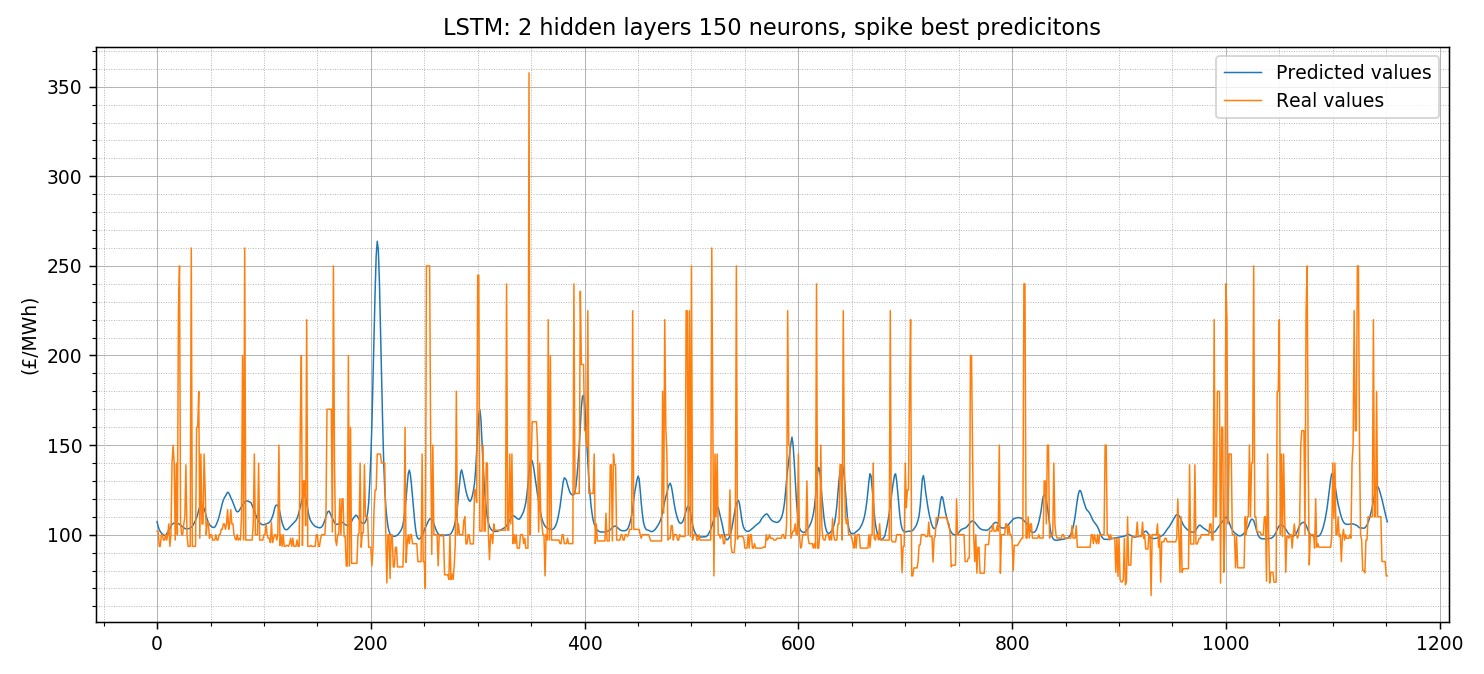

In [77]:
%matplotlib notebook

# 2 weeks = 14 (days) * 48 (SP) = 672 SP
predicted = y_pred_list[6]
plt.figure(figsize=(11,5))
plt.plot(predicted, label = 'Predicted values', linewidth = 0.8)
plt.plot(np.array(y_test), label = 'Real values', linewidth = 0.8)
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.ylabel('(£/MWh)')
plt.title('LSTM: 2 hidden layers 150 neurons, spike best predicitons')
plt.legend()
plt.tight_layout()

<IPython.core.display.Javascript object>


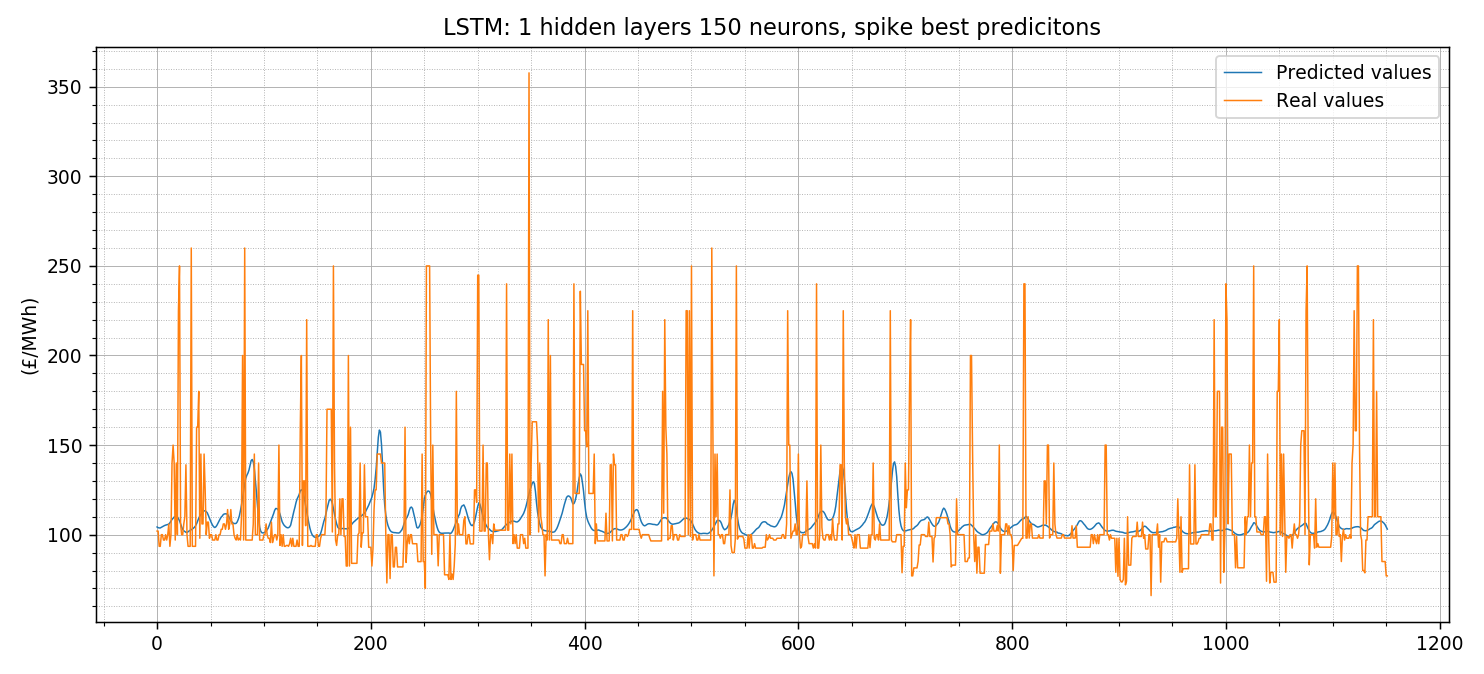

In [78]:
%matplotlib notebook

predicted = y_pred_list[2]
plt.figure(figsize=(11,5))
plt.plot(predicted, label = 'Predicted values', linewidth = 0.8)
plt.plot(np.array(y_test), label = 'Real values', linewidth = 0.8)
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5')
plt.grid(which='minor', linestyle=':', linewidth='0.5')
plt.ylabel('(£/MWh)')
plt.title('LSTM: 1 hidden layers 150 neurons, spike best predicitons')
plt.legend()
plt.tight_layout()